In [25]:
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

In [26]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
import spacy
import re

In [27]:
# Preprocessing Config
config = {
    'sep_pn': True, 
    'rm_pn': False, 
    'apply_lemmatization': True, 
    'apply_stemming': True, 
    'add_bigrams': True, 
    'rm_sw': False
}

In [28]:
nlp = spacy.load("en_core_web_sm")

# Add preprocessing functions
def pre_process(text, config):
    def separate_punctuation(text):
        text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text)
        text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)
        return text

    def remove_punctuation(text):
        text = re.sub(r"[.,;:!?'\"“”\(\)]", "", text)
        return text

    def tokenize_text(text):
        encoded_input = tokenizer(text, return_tensors='pt', add_special_tokens=True)
        tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0])
        return tokens

    def apply_stemming(tokens):
        stemmer = PorterStemmer()
        return [stemmer.stem(token) for token in tokens]

    def apply_lemmatization(tokens):
        lemmatizer = WordNetLemmatizer()
        return [lemmatizer.lemmatize(token) for token in tokens]

    def generate_ngrams_from_tokens(tokens, n):
        return [" ".join(gram) for gram in ngrams(tokens, n)]

    # Apply config options
    if config['sep_pn'] and not config['rm_pn']:
        text = separate_punctuation(text)
    if config['rm_pn'] and not config['sep_pn']:
        text = remove_punctuation(text)

    tokens = tokenize_text(text)
    if config['apply_stemming']:
        tokens = apply_stemming(tokens)
    if config['apply_lemmatization']:
        tokens = apply_lemmatization(tokens)
    if config['add_bigrams']:
        tokens += generate_ngrams_from_tokens(tokens, 2)
    if config['rm_sw']:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word.lower() not in stop_words]

    return " ".join(tokens)

In [29]:
# Load the pre-trained model and tokenizer
model_name = "bhadresh-savani/bert-base-uncased-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [30]:
# Create the emotion classifier pipeline
classifier = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

Device set to use cpu


/Users/angwang/miniforge3/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [31]:
def get_predictions_batch(texts, batch_size=32):
    """
    Get predictions for a list of texts in batches
    """
    all_predictions = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Predicting"):
        batch_texts = texts[i:i + batch_size]
        predictions = classifier(batch_texts)
        all_predictions.extend(predictions)
    
    return all_predictions

In [32]:
def format_predictions(predictions, emotion_mapping):
    """
    Convert raw predictions to the required format
    """
    formatted_preds = []
    for pred in predictions:
        # Create a dictionary of emotion scores
        scores = {p['label']: p['score'] for p in pred}
        # Map to our required emotions and format
        row = [scores.get(emotion_mapping.get(e, e), 0) for e in emotions]
        formatted_preds.append(row)
    
    return np.array(formatted_preds)

In [33]:
# Load data
train = pd.read_csv('../public_data_test/track_a/train/eng.csv')
val = pd.read_csv('../public_data_test/track_a/dev/eng.csv')
test = pd.read_csv('../public_data_test/track_a/test/eng.csv')

# Define emotions and mapping (model's labels to our labels)
emotions = ['joy', 'sadness', 'surprise', 'fear', 'anger']
emotion_mapping = {
    'joy': 'joy',
    'sadness': 'sadness',
    'surprise': 'surprise',
    'fear': 'fear',
    'anger': 'anger',
    'love': None  # We'll ignore this emotion as it's not in our target set
}

In [34]:
# Feature Extraction
vectorizer = CountVectorizer()
train_text = [pre_process(text, config) for text in train["text"]]
val_text = [pre_process(text, config) for text in val["text"]]
test_text = [pre_process(text, config) for text in test["text"]]

X_train = vectorizer.fit_transform(train_text).toarray()
X_val = vectorizer.transform(val_text).toarray()
X_test = vectorizer.transform(test_text).toarray()

In [35]:
# Convert labels to numpy arrays
y_train = train[emotions].values
y_val = val[emotions].values
y_test = test[emotions].values

In [36]:
# Get BERT embeddings for training data
print("Getting training BERT embeddings...")
train_raw_preds = get_predictions_batch(train['text'].tolist())
train_bert_features = format_predictions(train_raw_preds, emotion_mapping)

print("Getting validation BERT embeddings...")
val_raw_preds = get_predictions_batch(val['text'].tolist())
val_bert_features = format_predictions(val_raw_preds, emotion_mapping)

print("Getting test BERT embeddings...")
test_raw_preds = get_predictions_batch(test['text'].tolist())
test_bert_features = format_predictions(test_raw_preds, emotion_mapping)

# Combine CountVectorizer features with BERT embeddings
final_train_features = np.hstack([X_train, train_bert_features])
final_val_features = np.hstack([X_val, val_bert_features])
final_test_features = np.hstack([X_test, test_bert_features])

print(f"Final feature dimensions: {final_train_features.shape}")

Getting training BERT embeddings...


Predicting: 100%|██████████| 87/87 [07:33<00:00,  5.21s/it]


Getting validation BERT embeddings...


Predicting: 100%|██████████| 4/4 [00:14<00:00,  3.67s/it]


Getting test BERT embeddings...


Predicting: 100%|██████████| 87/87 [39:48<00:00, 27.45s/it]   


Final feature dimensions: (2768, 4079)


In [ ]:
# Convert probabilities to binary predictions (you can adjust the threshold)
threshold = 0.45
val_binary_preds = (val_bert_features > threshold).astype(int)
test_binary_preds = (test_bert_features > threshold).astype(int)

In [38]:
# Neural Network model
model = nn.Sequential(
    nn.Linear(final_train_features.shape[1], 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, y_train.shape[1])
)

In [39]:
# Training setup
features_tensor = torch.tensor(final_train_features, dtype=torch.float32)
labels_tensor = torch.tensor(y_train, dtype=torch.float32)
dataset = TensorDataset(features_tensor, labels_tensor)
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [40]:
# Calculate class weights
weights = y_train.sum(axis=0)/y_train.sum()
weights = max(weights)/weights

In [41]:
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor(weights))
optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [43]:
# Training loop
losses = []
for epoch in tqdm(range(401), desc="Training Loop"):
    for features, labels in data_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}: Loss: {round(loss.item(),3)}')
        torch.save(model.state_dict(), f'./model_checkpoints/net_epoch_{epoch}.pth')
        print(f"Saved epoch {epoch} weights")
        losses.append(round(loss.item(),3))

Training Loop:   0%|          | 1/401 [00:01<06:59,  1.05s/it]

Epoch 0: Loss: 0.839
Saved epoch 0 weights


Training Loop:  25%|██▌       | 101/401 [01:23<04:29,  1.11it/s]

Epoch 100: Loss: 0.886
Saved epoch 100 weights


Training Loop:  50%|█████     | 201/401 [02:57<02:55,  1.14it/s]

Epoch 200: Loss: 0.732
Saved epoch 200 weights


Training Loop:  75%|███████▌  | 301/401 [04:25<01:24,  1.19it/s]

Epoch 300: Loss: 0.897
Saved epoch 300 weights


Training Loop: 100%|██████████| 401/401 [05:44<00:00,  1.16it/s]

Epoch 400: Loss: 0.667
Saved epoch 400 weights


In [44]:
# Save predictions
def save_predictions(predictions, ids, filename):
    df_predictions = pd.DataFrame(predictions, columns=emotions)
    df_predictions['id'] = ids
    df_predictions = df_predictions[['id'] + emotions]
    df_predictions.to_csv(filename, index=False)
    print(f"Saved predictions to {filename}")

# Save validation and test predictions
from datetime import datetime
timestamp = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')

In [45]:
# After training loop, load the best model checkpoint
best_epoch = 400  # or whichever epoch had the best performance
model.load_state_dict(torch.load(f'./model_checkpoints/net_epoch_{best_epoch}.pth'))
model.eval()  # Set model to evaluation mode

# Generate predictions using the loaded model
with torch.no_grad():  # No need to track gradients during inference
    val_preds = model(torch.tensor(final_val_features, dtype=torch.float32))
    test_preds = model(torch.tensor(final_test_features, dtype=torch.float32))

# Convert to probabilities using sigmoid
sigmoid = nn.Sigmoid()
val_probs = sigmoid(val_preds).numpy()
test_probs = sigmoid(test_preds).numpy()

# Convert to binary predictions
threshold = 0.45
val_binary_preds = (val_probs > threshold).astype(int)
test_binary_preds = (test_probs > threshold).astype(int)

# Save predictions
timestamp = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')
save_predictions(
    val_binary_preds,
    val['id'],
    f'../results/val_predictions_epoch_{best_epoch}_{timestamp}.csv'
)

save_predictions(
    test_binary_preds,
    test['id'],
    f'../results/test_predictions_epoch_{best_epoch}_{timestamp}.csv'
)

/var/folders/sx/hkqgssrx0jd_jb2_792hz_hm0000gp/T/ipykernel_2128/3075013302.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./model_che

Saved predictions to ../results/val_predictions_epoch_400_2025-01-30_14_58_37.csv
Saved predictions to ../results/test_predictions_epoch_400_2025-01-30_14_58_37.csv


In [49]:
from sklearn.metrics import classification_report

# Evaluate validation predictions
print("\nValidation Set Performance:")
print(classification_report(
    val[emotions].values,
    val_binary_preds,
    target_names=emotions
))


Validation Set Performance:
              precision    recall  f1-score   support

         joy       0.56      0.71      0.63        31
     sadness       0.47      0.77      0.59        35
    surprise       0.36      0.77      0.49        31
        fear       0.55      1.00      0.71        63
       anger       0.35      0.69      0.47        16

   micro avg       0.48      0.84      0.61       176
   macro avg       0.46      0.79      0.58       176
weighted avg       0.49      0.84      0.61       176
 samples avg       0.51      0.77      0.58       176



/Users/angwang/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Performing threshold grid search...


Testing thresholds:   0%|          | 0/16 [00:00<?, ?it/s]/Users/angwang/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/angwang/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/angwang/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
 


Best Results:
Best threshold: 0.450
Best Macro F1: 0.577


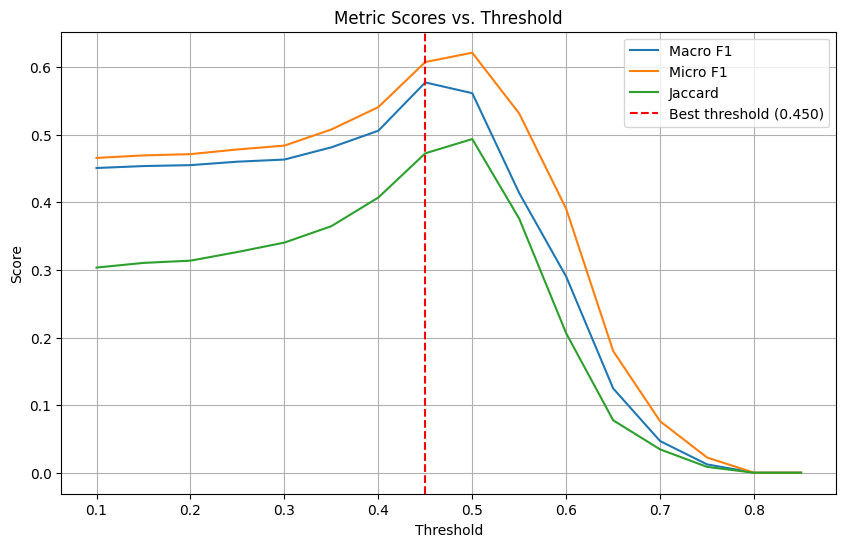


Final Validation Performance with Best Threshold:
              precision    recall  f1-score   support

         joy       0.56      0.71      0.63        31
     sadness       0.47      0.77      0.59        35
    surprise       0.36      0.77      0.49        31
        fear       0.55      1.00      0.71        63
       anger       0.35      0.69      0.47        16

   micro avg       0.48      0.84      0.61       176
   macro avg       0.46      0.79      0.58       176
weighted avg       0.49      0.84      0.61       176
 samples avg       0.51      0.77      0.58       176

Saved predictions to ../results/val_predictions_epoch_400_threshold_0.450_2025-01-30_15_09_23.csv
Saved predictions to ../results/test_predictions_epoch_400_threshold_0.450_2025-01-30_15_09_23.csv


/Users/angwang/miniforge3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [51]:
from sklearn.metrics import f1_score, jaccard_score, classification_report

# Grid search for optimal threshold
thresholds = np.arange(0.1, 0.9, 0.05)  # Test thresholds from 0.1 to 0.9 with 0.05 steps
best_threshold = 0
best_macro_f1 = 0
results = []

print("Performing threshold grid search...")
for threshold in tqdm(thresholds, desc="Testing thresholds"):
    # Convert probabilities to binary predictions
    val_binary_preds = (val_probs > threshold).astype(int)
    
    # Calculate metrics
    macro_f1 = f1_score(val[emotions].values, val_binary_preds, average='macro')
    micro_f1 = f1_score(val[emotions].values, val_binary_preds, average='micro')
    jaccard = jaccard_score(val[emotions].values, val_binary_preds, average='samples')
    
    results.append({
        'threshold': threshold,
        'macro_f1': macro_f1,
        'micro_f1': micro_f1,
        'jaccard': jaccard
    })
    
    # Update best threshold if we found better macro F1
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_threshold = threshold

# Convert results to DataFrame for easy viewing
results_df = pd.DataFrame(results)
print("\nBest Results:")
print(f"Best threshold: {best_threshold:.3f}")
print(f"Best Macro F1: {best_macro_f1:.3f}")

# Optional: Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results_df['threshold'], results_df['macro_f1'], label='Macro F1')
plt.plot(results_df['threshold'], results_df['micro_f1'], label='Micro F1')
plt.plot(results_df['threshold'], results_df['jaccard'], label='Jaccard')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best threshold ({best_threshold:.3f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metric Scores vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Use the best threshold for final predictions
val_binary_preds = (val_probs > best_threshold).astype(int)
test_binary_preds = (test_probs > best_threshold).astype(int)

# Print final performance with best threshold
print("\nFinal Validation Performance with Best Threshold:")
print(classification_report(
    val[emotions].values,
    val_binary_preds,
    target_names=emotions
))

# Save predictions with best threshold
timestamp = datetime.now().strftime('%Y-%m-%d_%H_%M_%S')
save_predictions(
    val_binary_preds,
    val['id'],
    f'../results/val_predictions_epoch_{best_epoch}_threshold_{best_threshold:.3f}_{timestamp}.csv'
)

save_predictions(
    test_binary_preds,
    test['id'],
    f'../results/test_predictions_epoch_{best_epoch}_threshold_{best_threshold:.3f}_{timestamp}.csv'
)

# Save threshold search results
results_df.to_csv(f'../results/threshold_search_results_{timestamp}.csv', index=False)

Test Set Scores:

Macro F1	0.5399
Micro F1	0.5956
Anger	0.3497
Fear	0.7195
Joy	0.508
Sadness	0.5591
Surprise	0.563
